# 자동차 이미지 인식

AWS 환경에서 사진으로부터 자동차, 보행자 등을 인식하는 ML 모델을 개발하고 이를 IoT로 배포하는 예제코드입니다. 

- 데이터 소스 : https://www.kaggle.com/twaldo/kitti-object-detection (under Creative Commons Attribution-NonCommercial-ShareAlike 3.0 license. 데이터 다운로드 후 readme.txt 참조)
- 데이터셋이 11기가이므로 실행을 위해서는 그 이상의 저장공간이 필요함 

## 1. 학습데이터 준비

#### 1-1. 데이터 다운로드 
- Kaggle 사이트에서 My Account > Create New API Token > kaggle.json 다운로드
- 해당 파일을 노트북 다음 경로에 업로드 (~/.kaggle/kaggle.json)

In [30]:
!pip install kaggle

In [5]:
!mv ~/SageMaker/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d twaldo/kitti-object-detection

100%|█████████████████████████████████████▉| 11.5G/11.5G [02:36<00:00, 86.9MB/s]
100%|██████████████████████████████████████| 11.5G/11.5G [02:36<00:00, 79.0MB/s]


In [10]:
!unzip -q kitti-object-detection.zip
!rm kitti-object-detection.zip

#### 1-2. 다운받은 이미지 살펴보기

In [89]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

In [2]:
!ls kitti_single/training/image_2 |head -n 3

000000.png
000001.png
000002.png
ls: write error: Broken pipe


In [3]:
!ls kitti_single/training/label_2 |head -n 3

000000.txt
000001.txt
000002.txt
ls: write error: Broken pipe


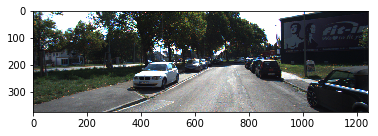

In [4]:
img = Image.open('kitti_single/training/image_2/000010.png')
plt.imshow(img)

In [5]:
dimension = np.array(img).shape
dimension

(375, 1242, 3)

#### 1-3. 레이블 살펴보기

레이블 파일은 15개의 컬럼을 가지며 다음 포맷으로 구성됨 **- 본 예제에서는 type, bbx, score만 사용**
- **type**: 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc' or 'DontCare'
- truncated: bounding box에서 이미지가 잘렸는지 여부, from 0 (non-truncated) to 1 (truncated)
- occluded: 폐색(occlusion) 상태, 0 = fully visible, 1 = partly occluded, 2 = largely occluded, 3 = unknown
- alpha: 관찰각, [-pi..pi]
- **bbx**: 연속 4개 컬럼. left, top, right, bottom 픽셀좌표
- dimensions: 연속 3개 컬럼. height, width, length (미터단위)
- location: 연속 3개 컬럼. 3D 카메라좌표 위치 x,y,z (미터단위)
- rotation_y: y축으로 카메라 회전 [-pi..pi]
- **score**: confidence in detection (설명에만 존재하고 실제 파일에는 없었음)

In [6]:
with open('kitti_single/training/label_2/000003.txt','r') as f:
    l = [r.split() for r in f.readlines()]
l[0][:8]

['Car', '0.00', '0', '1.55', '614.24', '181.78', '727.31', '284.77']

In [7]:
len(l[0])

15

#### 1-4. 레이블 편집
- 레이블 변환함수 (Type, confidence, bbx 형식으로 변환)

In [8]:
def get_label(labelpath, h=375, w=1242, relative=False):
    with open(labelpath,'r') as f:
        l = [r.split() for r in f.readlines()]
    d = [[float(e) if (idx>0) else e for idx, e in zip(range(len(i)),i)] for i in l]
    dets = [[i[0],1,i[4]/w,i[5]/h,i[6]/w,i[7]/h] for i in d] if relative else [[i[0],1,i[4],i[5],i[6],i[7]] for i in d]
    return dets

get_label('kitti_single/training/label_2/000003.txt', relative=False)

[['Car', 1, 614.24, 181.78, 727.31, 284.77],
 ['DontCare', 1, 5.0, 229.89, 214.12, 367.61],
 ['DontCare', 1, 522.25, 202.35, 547.77, 219.71]]

In [9]:
code = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

#### 1-5. bounding box display 함수 정의하고 이미지에서 확인하기

In [293]:
import random
import matplotlib.image as mpimg

def visualize_detection(img_file, dets, code, thresh=0.6, ignore=True, relative=False, char_idx=True):
        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if (score < thresh) or (ignore and klass =='DontCare'):
                continue
            
            cls_id = code.index(klass) if char_idx else int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = x0 * width if relative else x0
            ymin = y0 * height if relative else y0
            xmax = x1 * width if relative else x1
            ymax = y1 * height if relative else y1
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            #if classes and len(classes) > cls_id:class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(code[cls_id], score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')

        plt.show()

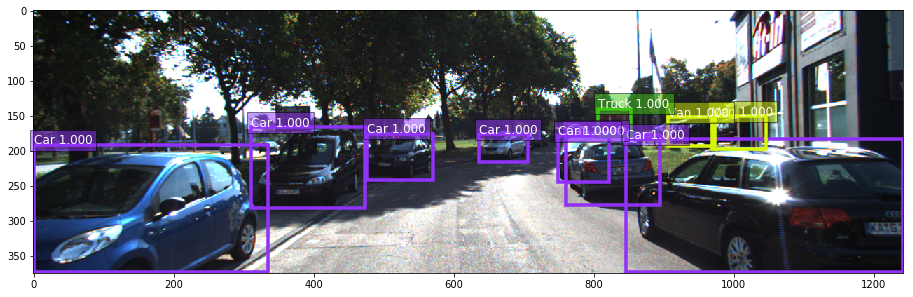

In [201]:
plt.figure(figsize=(16, 16*375/1242))
label = get_label('kitti_single/training/label_2/000099.txt')
visualize_detection('kitti_single/training/image_2/000099.png', label, code, 0.8)

In [202]:
label

[['Car', 1, 0.0, 192.19, 334.16, 374.0],
 ['Car', 1, 846.35, 184.06, 1241.0, 374.0],
 ['Car', 1, 311.03, 166.77, 473.94, 282.46],
 ['Car', 1, 476.22, 175.94, 570.51, 241.53],
 ['Car', 1, 760.24, 178.07, 894.06, 277.07],
 ['Car', 1, 749.22, 179.42, 821.9, 244.62],
 ['Car', 1, 635.86, 176.79, 705.58, 216.29],
 ['Van', 1, 968.2, 150.98, 1045.59, 197.64],
 ['Van', 1, 906.67, 152.6, 973.7, 193.83],
 ['Truck', 1, 806.52, 140.24, 852.48, 179.7],
 ['DontCare', 1, 709.32, 170.06, 735.18, 191.97],
 ['DontCare', 1, 568.94, 176.06, 593.98, 187.56],
 ['DontCare', 1, 738.73, 152.1, 793.98, 192.77],
 ['DontCare', 1, 883.52, 154.19, 930.44, 179.23]]


---
## 2. SageMaker Object Detection 포맷으로 변환 및 S3업로드
- SageMaker Object Detection은 jsonline 또는 recordio의 두가지 형식을 지원함 (https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html#object-detection-inputoutput)
- 본 예제는 비교적 데이터사이즈가 크기 때문에 recordio사용 예정 (성능이 좋고 pipe mode 이용 등에서 더 편리함)
- recordio 변환 코드는 다음 링크 참조 : https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb


#### 2-1. RecordIO용 lst 파일 생성
- 레이블 파일로부터 lst 파일 만들기

In [57]:
lfiles = os.listdir('kitti_single/training/label_2')
len(lfiles)

7481

In [225]:
def label_to_list(lfiles) :
    lst = []
    for idx, f in zip(range(len(lfiles)),lfiles):
        lfile = 'kitti_single/training/label_2/{}'.format(f)
        ifile = 'kitti_single/training/image_2/{}.png'.format(f.split('.')[0])

        l = []
        labels = get_label(lfile, relative=True)
        for label in labels:
            l.append(float(code.index(label[0])))
            l.extend(label[2:6])

        lst_rec = []
        lst_rec.extend([idx, 2, 5])
        lst_rec.extend(l)
        lst_rec.append(ifile)
        lst.append(lst_rec)
    return lst

# label 파일목록으로부터 index + label + 파일경로 list 생성
lst = label_to_list(lfiles)
lst[100]

[100,
 2,
 5,
 0.0,
 0.6440257648953301,
 0.43978666666666666,
 0.7517149758454106,
 0.5796,
 0.0,
 0.5223107890499196,
 0.4392266666666667,
 0.5457487922705314,
 0.50392,
 'kitti_single/training/image_2/006353.png']

In [227]:
print(lst[0])

[0, 2, 5, 3.0, 0.755402576489533, 0.40210666666666667, 0.7999516908212561, 0.8126933333333333, 'kitti_single/training/image_2/005329.png']


#### 2-2. Train / Valid set으로 split & tsv 저장

In [228]:
split = len(lst) * 8 //10
lst_train = lst[:split]
lst_valid = lst[split:]

In [229]:
def write_tsv(filename, lst):
    with open(filename, 'w', newline='') as f_output:
        tsv_output = csv.writer(f_output, delimiter='\t')
        for r in lst:
            tsv_output.writerow(r)

* lst list를 tsv 파일로 저장

In [230]:
!mkdir recio

mkdir: cannot create directory ‘recio’: File exists


In [231]:
write_tsv('recio/kitti_train.lst', lst_train)
write_tsv('recio/kitti_valid.lst', lst_valid)

In [232]:
!head -n 3 recio/kitti_train.lst

0	2	5	3.0	0.755402576489533	0.40210666666666667	0.7999516908212561	0.8126933333333333	kitti_single/training/image_2/005329.png
1	2	5	0.0	0.35784219001610307	0.4910666666666667	0.42173913043478256	0.6211466666666667	0.0	0.0	0.5126133333333333	0.21185185185185185	0.92952	0.0	0.2512157809983897	0.5139466666666667	0.33417874396135266	0.6698933333333333	0.0	0.5064734299516908	0.4739466666666666	0.5325281803542673	0.54888	0.0	0.5758373590982288	0.4451733333333333	0.6589935587761675	0.5304266666666667	0.0	0.5723027375201288	0.4253866666666667	0.6438325281803543	0.5259733333333334	1.0	0.7329388083735909	0.39416	0.8103381642512077	0.48693333333333333	8.0	0.6551771336553945	0.41394666666666663	0.7315297906602254	0.4862666666666666	8.0	0.46646537842190017	0.4639466666666666	0.4748872785829307	0.50016	8.0	0.5293719806763285	0.45005333333333336	0.5738566827697262	0.4890666666666667	8.0	0.4186634460547504	0.47784	0.4497262479871175	0.5085066666666667	8.0	0.485756843800322	0.47226666666666667	0.50591

#### 2-3. lst로부터 RecordIO파일 생성

In [233]:
%%time
# !python tools/im2rec.py ./example_rec ./example/ --recursive --list --num-thread 8
!python tools/im2rec.py --pack-label --num-thread 8 recio/kitti_train.lst ./
!python tools/im2rec.py --pack-label --num-thread 8 recio/kitti_valid.lst ./

Creating .rec file from /home/ec2-user/SageMaker/car-detect/recio/kitti_train.lst in /home/ec2-user/SageMaker/car-detect/recio
time: 0.21509194374084473  count: 0
time: 2.7410342693328857  count: 1000
time: 2.764127254486084  count: 2000
time: 2.7864863872528076  count: 3000
time: 2.7104170322418213  count: 4000
time: 2.6686244010925293  count: 5000
Creating .rec file from /home/ec2-user/SageMaker/car-detect/recio/kitti_valid.lst in /home/ec2-user/SageMaker/car-detect/recio
time: 0.05369758605957031  count: 0
time: 2.8060123920440674  count: 1000
CPU times: user 414 ms, sys: 89.6 ms, total: 504 ms
Wall time: 26.1 s


In [234]:
!ls -al recio/

total 1517360
drwxrwxr-x 2 ec2-user ec2-user       4096 May 18 09:24 .
drwxrwxr-x 6 ec2-user ec2-user       4096 May 18 16:23 ..
-rw-rw-r-- 1 ec2-user ec2-user      89259 May 18 16:24 kitti_train.idx
-rw-rw-r-- 1 ec2-user ec2-user    3402201 May 18 16:24 kitti_train.lst
-rw-rw-r-- 1 ec2-user ec2-user 1240320252 May 18 16:24 kitti_train.rec
-rw-rw-r-- 1 ec2-user ec2-user      21906 May 18 16:24 kitti_valid.idx
-rw-rw-r-- 1 ec2-user ec2-user     840504 May 18 16:24 kitti_valid.lst
-rw-rw-r-- 1 ec2-user ec2-user  309077348 May 18 16:24 kitti_valid.rec


#### 2-4. S3 업로드 (train/valid set)

In [241]:
import sagemaker
from sagemaker import get_execution_role
import json

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::308961792850:role/service-role/AmazonSageMaker-ExecutionRole-20200220T105738


In [236]:
bucket = sess.default_bucket() 
s3_prefix = 'kitti-od'

In [237]:
%%time
s3_train_data = sess.upload_data(path='./recio/kitti_train.rec', key_prefix=s3_prefix + '/train')
s3_valid_data = sess.upload_data(path='./recio/kitti_valid.rec', key_prefix=s3_prefix + '/validation')
print(s3_train_data)
print(s3_valid_data)

s3://sagemaker-us-east-1-308961792850/kitti-od/train/kitti_train.rec
s3://sagemaker-us-east-1-308961792850/kitti-od/validation/kitti_valid.rec
CPU times: user 10.1 s, sys: 8.33 s, total: 18.5 s
Wall time: 18.6 s



---
## 3. SageMaker Object Detecion

#### 3-1. Object Detection 알고리즘 선택

In [238]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest


In [239]:
s3_output_location = 's3://{}/{}/output'.format(bucket, s3_prefix)
s3_output_location

's3://sagemaker-us-east-1-308961792850/kitti-od/output'

#### 3-2. Estimator and Hyperparameter 선언

In [338]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         tags=[{"Key":"project","Value":"object-detection-car"}],
                                         base_job_name='od-car',
                                         sagemaker_session=sess)

In [343]:
num_classes = len(code)
n_train = len(lst_train)
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=num_classes,
                             mini_batch_size=16,
                             epochs=30,
                             learning_rate=0.0001,
#                              learning_rate=0.00001,
#                              learning_rate=0.000001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='adam',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=350,
                             num_training_samples=n_train)

In [344]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_valid_data, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

#### 3-3. Incremental training 시에는 아래 코드 추가로 실행

- 만약 처음 실행시 주석 해제하고 실행하시면 s3_model_data 를 찾지 못하는 에러가 발생합니다. 무시하고 진행하시면 됩니다.

In [345]:
# # incremental learning 시 아래 주석해제
# model_data = sagemaker.session.s3_input(s3_model_data, distribution='FullyReplicated', 
#                              content_type='application/x-sagemaker-model', s3_data_type='S3Prefix')
# data_channels = {'train': train_data, 'validation': validation_data, 'model': model_data}

In [ ]:
# incremental learning 시 아래 주석해제
model_data = sagemaker.session.s3_input(s3_model_data, distribution='FullyReplicated', 
                             content_type='application/x-sagemaker-model', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data, 'model': model_data}

#### 3-4. 학습 시작

In [346]:
%%time
od_model.fit(data_channels, wait=True)

2020-05-19 02:55:06 Starting - Starting the training job...
2020-05-19 02:55:09 Starting - Launching requested ML instances......
2020-05-19 02:56:22 Starting - Preparing the instances for training.........
2020-05-19 02:58:05 Downloading - Downloading input data...
2020-05-19 02:58:36 Training - Downloading the training image...
2020-05-19 02:58:56 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[05/19/2020 02:58:59 INFO 140001408792384] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momen

#### 3-5. 작업결과 매트릭 체크

In [256]:
from sagemaker.analytics import TrainingJobAnalytics
latest_job_name = od_model.latest_training_job.job_name
job_metric = TrainingJobAnalytics(training_job_name=latest_job_name, metric_names=['validation:mAP']).dataframe()
job_metric[:10]

,timestamp,metric_name,value
0,0.0,validation:mAP,0.116134
1,120.0,validation:mAP,0.162141
2,240.0,validation:mAP,0.186803
3,360.0,validation:mAP,0.231941
4,480.0,validation:mAP,0.262802
5,600.0,validation:mAP,0.279791
6,720.0,validation:mAP,0.319517
7,840.0,validation:mAP,0.306869
8,960.0,validation:mAP,0.342189
9,1140.0,validation:mAP,0.350910


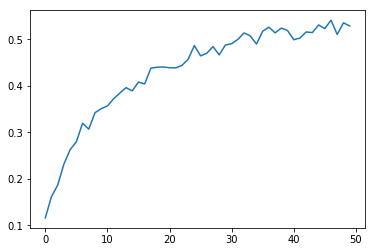

In [257]:
plt.plot(job_metric['value'])

#### 3-6. 다음은 Incremental Training의 실행결과입니다. (optional)

- 2nd incremental training result ( learning rate을 1/10으로 로정)

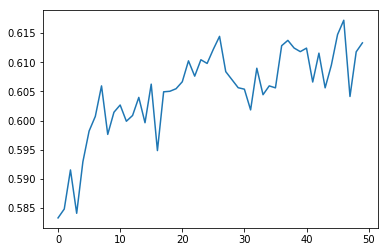

In [312]:
from sagemaker.analytics import TrainingJobAnalytics
latest_job_name = od_model.latest_training_job.job_name
job_metric = TrainingJobAnalytics(training_job_name=latest_job_name, metric_names=['validation:mAP']).dataframe()
plt.plot(job_metric['value'])

- 세번째 작업결과 (learning rate 유지)

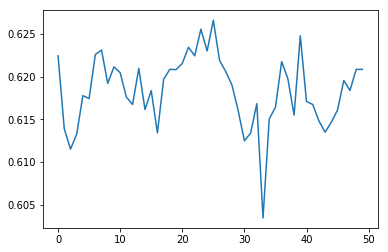

In [321]:
from sagemaker.analytics import TrainingJobAnalytics
latest_job_name = od_model.latest_training_job.job_name
job_metric = TrainingJobAnalytics(training_job_name=latest_job_name, metric_names=['validation:mAP']).dataframe()
plt.plot(job_metric['value'])

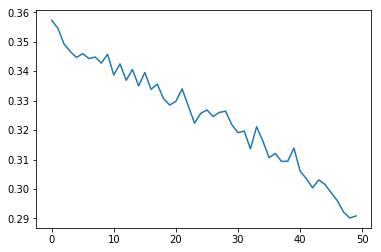

In [322]:
from sagemaker.analytics import TrainingJobAnalytics
latest_job_name = od_model.latest_training_job.job_name
job_metric = TrainingJobAnalytics(training_job_name=latest_job_name, metric_names=['train:cross_entropy']).dataframe()
plt.plot(job_metric['value'])

* 네번째 작업결과 (learning rate 1/2로 조정, epoch 10으로 조정)

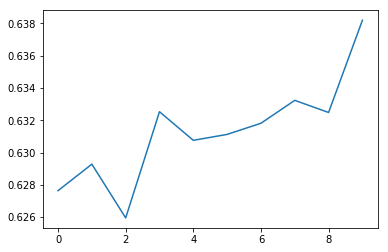

In [333]:
from sagemaker.analytics import TrainingJobAnalytics
latest_job_name = od_model.latest_training_job.job_name
job_metric = TrainingJobAnalytics(training_job_name=latest_job_name, metric_names=['validation:mAP']).dataframe()
plt.plot(job_metric['value'])

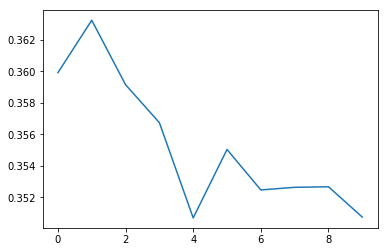

In [334]:
from sagemaker.analytics import TrainingJobAnalytics
latest_job_name = od_model.latest_training_job.job_name
job_metric = TrainingJobAnalytics(training_job_name=latest_job_name, metric_names=['train:cross_entropy']).dataframe()
plt.plot(job_metric['value'])

- 다섯번째 작업 (파라미터 조정없이 30 epoch 실행)

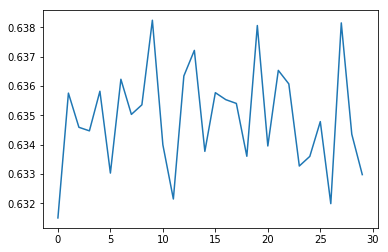

In [347]:
from sagemaker.analytics import TrainingJobAnalytics
latest_job_name = od_model.latest_training_job.job_name
job_metric = TrainingJobAnalytics(training_job_name=latest_job_name, metric_names=['validation:mAP']).dataframe()
plt.plot(job_metric['value'])

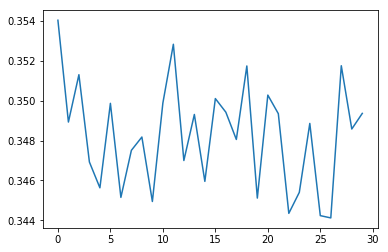

In [348]:
from sagemaker.analytics import TrainingJobAnalytics
latest_job_name = od_model.latest_training_job.job_name
job_metric = TrainingJobAnalytics(training_job_name=latest_job_name, metric_names=['train:cross_entropy']).dataframe()
plt.plot(job_metric['value'])

#### 3-7. Incremental training을 위한 모델 확인

- 아래 과정을 통해 s3_model_data 경로를 정의한 후 3-2 단계부터 다시 학습을 수행할 수 있습니다.  
- **재실행시 첫번째 학습된 모델을 기반으로 증분학습을 할 수 있도록 3-3 단계의 주석을 해제합니다.**
- 작업결과에 따라 Learning rate 등 하이퍼파라미터를 재조정합니다.

In [349]:
latest_job_name

'od-car-2020-05-19-02-55-06-621'

In [350]:
s3_model_data = '{}/{}/output/model.tar.gz'.format(s3_output_location,latest_job_name)
s3_model_data

's3://sagemaker-us-east-1-308961792850/kitti-od/output/od-car-2020-05-19-02-55-06-621/output/model.tar.gz'

In [351]:
!aws s3 ls {s3_model_data}

2020-05-19 04:15:30  107493075 model.tar.gz



---
## 4. Hosting & Inference on SageMaker

#### 4-1. deployment

In [371]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

-----------------!

#### 4-2. endpint 호출

In [264]:
import boto3 
runtime = boto3.client(service_name='runtime.sagemaker')

In [263]:
ep = object_detector.endpoint

In [355]:
# Image.openImage.open('kitti_single/training/image_2/000010.png')
def invoke_detector(filename, ep):
    with open(filename, 'rb') as image:
        f = image.read()
        b = bytearray(f)
    endpoint_response = runtime.invoke_endpoint(EndpointName=ep,
                                           ContentType='image/jpeg',
                                           Body=b)
    return json.loads(endpoint_response['Body'].read())

In [298]:
filename = 'kitti_single/training/image_2/000010.png'
result = invoke_detector(filename, ep)
result['prediction'][:3]

[[0.0,
  0.9983187913894653,
  0.2965947091579437,
  0.5010779500007629,
  0.4455583989620209,
  0.8005997538566589],
 [0.0,
  0.9794665575027466,
  0.6586355566978455,
  0.47797393798828125,
  0.7386180758476257,
  0.681899905204773],
 [0.0,
  0.9606328010559082,
  0.45548853278160095,
  0.4744578003883362,
  0.5080062747001648,
  0.6075308918952942]]

#### 4-3. 결과 확인

- 호출결과 시각화

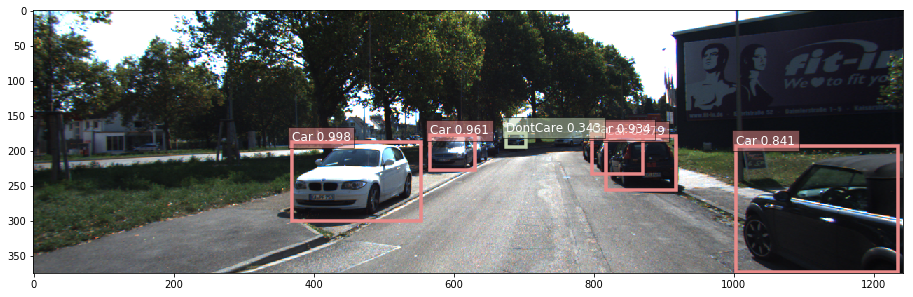

In [311]:
filename = 'kitti_single/training/image_2/000010.png'
plt.figure(figsize=(16, 16*375/1242))
# label = get_label('kitti_single/training/label_2/000099.txt')
label = invoke_detector(filename, ep)['prediction']
visualize_detection(filename, label, code, 0.3, relative=True, char_idx=False)

- 임의 파일 테스트 (000999.png)

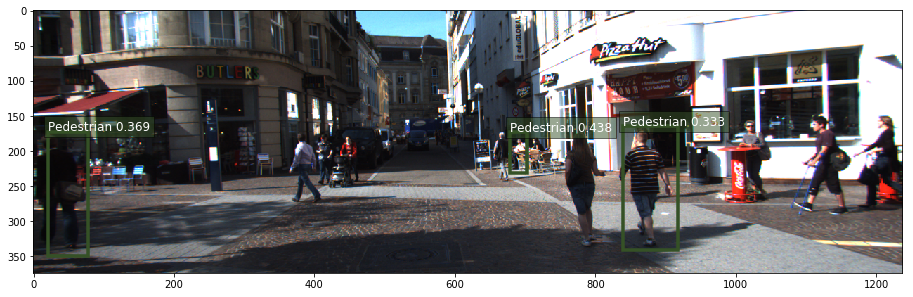

In [302]:
filename = 'kitti_single/training/image_2/000999.png'
plt.figure(figsize=(16, 16*375/1242))
label = invoke_detector(filename, ep)['prediction']
visualize_detection(filename, label, code, 0.3, relative=True, char_idx=False)

- Ground truth와 비교

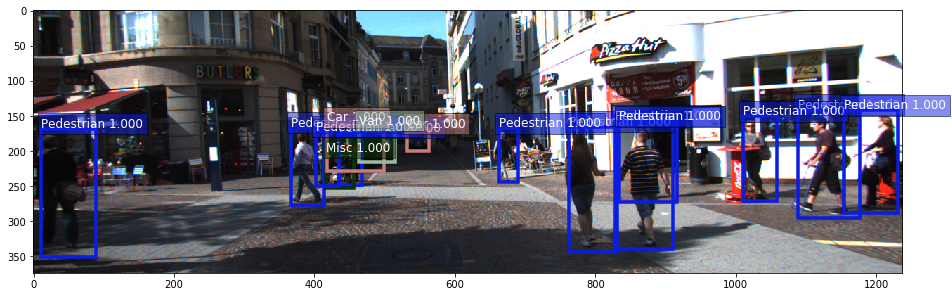

In [305]:
filename = 'kitti_single/training/image_2/000999.png'
plt.figure(figsize=(16, 16*375/1242))
label = get_label('kitti_single/training/label_2/000999.txt')
visualize_detection(filename, label, code, 0.3, relative=False, char_idx=True)

- Incremental training 후 결과 : Incremtal training 결과로 endpoint를 재생성한 후 동일이미지 재테스트

In [372]:
ep = object_detector.endpoint

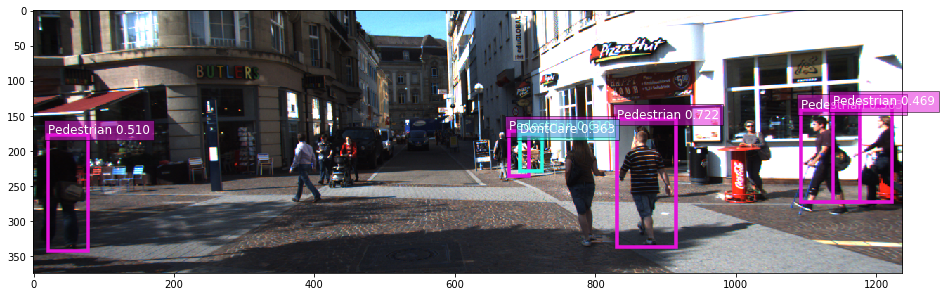

In [378]:
filename = 'kitti_single/training/image_2/000999.png'
plt.figure(figsize=(16, 16*375/1242))
label = invoke_detector(filename, ep)['prediction']
visualize_detection(filename, label, code, 0.3, relative=True, char_idx=False)

- 결과가 나아지기는 했으나 완벽한 성능은 아닙니다.
- 추가 성능 확보를 위해 더 많은 샘플의 확보나 데이터의 증강 등의 방법을 더 고려할 수 있습니다.

---
## 5. Clean up

* 추가비용을 막기위해 endpoint를 삭제합니다.

In [369]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)

- 삭제방법은 여러가지가 있습니다. 다음은 boto3를 통해 endpoint 리스트를 조회하고 EndpointName이용하여 삭제하는 코드 샘플입니다.

In [360]:
sm = boto3.client('sagemaker')
sm.list_endpoints()

In [367]:
sm.delete_endpoint(EndpointName='od-car-2020-05-19-02-55-06-621')

{'ResponseMetadata': {'RequestId': '3220c9f5-7834-41ab-847b-1a0c248ec322',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3220c9f5-7834-41ab-847b-1a0c248ec322',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 19 May 2020 05:48:17 GMT'},
  'RetryAttempts': 0}}